In [ ]:
!nvidia-smi


Wed Jul 26 23:16:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#1. Importing Packages
# we will import the libraries and packages we will be using in this project and print their version numbers.


In [ ]:
# Importing libraries
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

In [ ]:
# Image Quality Metrics
# We Define a couple of functions that we can use to calculate the PSNR, MSE, and SSIM.
#The structural similiarity (SSIM) index was imported directly from the scikit-image library;
# we are defining our own functions for the PSNR and MSE

In [ ]:
# Defining Image Quality Matric Functions
def psnr(target, ref):

    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])

    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))

    return scores

In [ ]:
#  Preparing ImagesÂ¶
#For this project, we used the same images that were used in the original SRCNN paper. We can download these images from http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html. The .zip file identified as the MATLAB code contains the images we want. Copy both the Set5 and Set14 datasets into a new folder called 'source'.

# Now we have some images, we produced low resolution versions of these same images.
#We can accomplish this by resizing the images, both downwards and upwards, using OpeCV.
#There are several interpolation methods that can be used to resize images; however, we used using bilinear interpolation.

#Once we produce these low resolution images, we can save them in a new folder.

In [ ]:
# Preparing Images (degraded) by resizing
cwd = os.getcwd()  # Get the current working directory (cwd)
def prepare_images(path, factor):

    # loop through the files in the directory
    for file in os.listdir(path):
        try:
          # open the file
          img = cv2.imread(path + '/' + file)

          # find old and new image dimensions
          h, w, _ = img.shape
          new_height = int(h / factor)
          new_width = int(w / factor)

          # resize the image - down
          img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)

          # resize the image - up
          img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)

          # save the image
          print('Saving {}'.format(file))
          cv2.imwrite('images/{}'.format(file), img)
        except:
          print('ERROR for file-', file, '!')
          pass

prepare_images('source/', 2)

ERROR for file- .ipynb_checkpoints !
Saving WIN_20230726_17_26_16_Pro.jpg
Saving flowers.png


In [ ]:
# Testing Low Resolution Images
# To ensure that our image quality metrics are being calculated correctly and that the images were effectively degraded
# lets calculate the PSNR, MSE, and SSIM between our reference images and the degraded images that we just prepared.

In [ ]:
# Testing Quality difference between source and image (degraded)
for file in os.listdir('images/'):
    try:
      # open target and reference images
      target = cv2.imread('images/{}'.format(file))
      ref = cv2.imread('source/{}'.format(file))

      # calculate score
      scores = compare_images(target, ref)

      # print all three scores with new line characters (\n)
      print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))
    except:
      pass

<ipython-input-14-bc3890bc9768>:28: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel =True))


WIN_20230726_17_26_16_Pro.jpg
PSNR: 40.14405242615695
MSE: 18.871063368055555
SSIM: 0.9792109741114484

flowers.png
PSNR: 24.853716439259074
MSE: 638.0136519337017
SSIM: 0.8105634469068868



In [ ]:
# Now that we have our low resolution images and all three image quality metrics functioning properly,
# we build the SRCNN. In Keras, it's as simple as adding layers one after the other.
# The achitecture and hyper parameters of the SRCNN network can be obtained from the publication referenced above.

In [ ]:
# Defining SRCNN Model
def model():

    # define model type
    SRCNN = Sequential()

    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))

    # define optimizer
    adam = Adam(learning_rate=0.0003)

    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])

    return SRCNN

In [ ]:
# Defining SRCNN Model
srcnn = model()
srcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 128)   10496     
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    73792     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# . Deploying the SRCNN
# We have defined our model, we can use it for single-image super-resolution.
# However, before we do this, we will need to define a couple of image processing functions.
# Furthermore, it will be necessary to preprocess the images extensively before using them as inputs to the network.
# This processing will include cropping and color space conversions.

1/1 [==============================] - 1s 800ms/step


<ipython-input-14-bc3890bc9768>:28: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel =True))


Degraded Image: 
PSNR: 24.714602621262493
MSE: 658.7814373740964
SSIM: 0.8155557528277376

Reconstructed Image: 
PSNR: 26.607296495117744
MSE: 426.06118023462494
SSIM: 0.8555326822513448



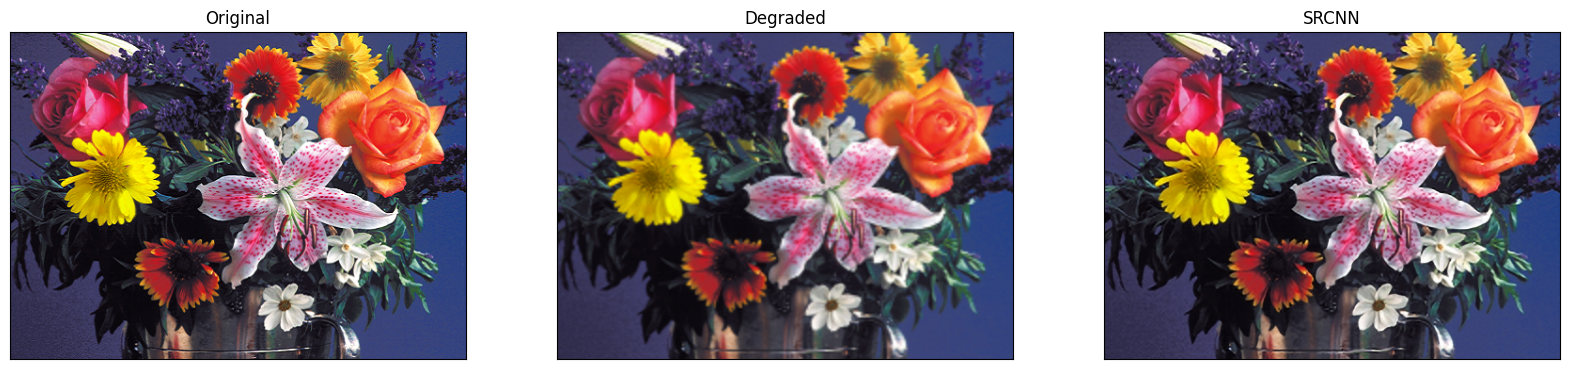

In [ ]:
# Image Processing Functions
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img
# define main prediction function

def predict(image_path):

    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')

    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))

    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)

    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)

    # create image slice and normalize
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255

    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)

    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)

    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)

    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)

    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))

    # return images and scores
    return ref, degraded, output, scores
#ref, degraded, output, scores = predict('images/flowers.bmp'), changed bmp to png
ref, degraded, output, scores = predict('images/flowers.png')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
# Once we have tested our network, we can perform single-image super-resolution on all of our input images.
# After processing, we calculated the PSNR, MSE, and SSIM on the images that we produce.
# We saved these images directly or create subplots to conveniently display the original, low resolution, and high resolution images side by side.

1/1 [==============================] - 4s 4s/step


<ipython-input-14-bc3890bc9768>:28: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel =True))


Saving WIN_20230726_17_26_16_Pro.jpg
1/1 [==============================] - 1s 1s/step
Saving flowers.png


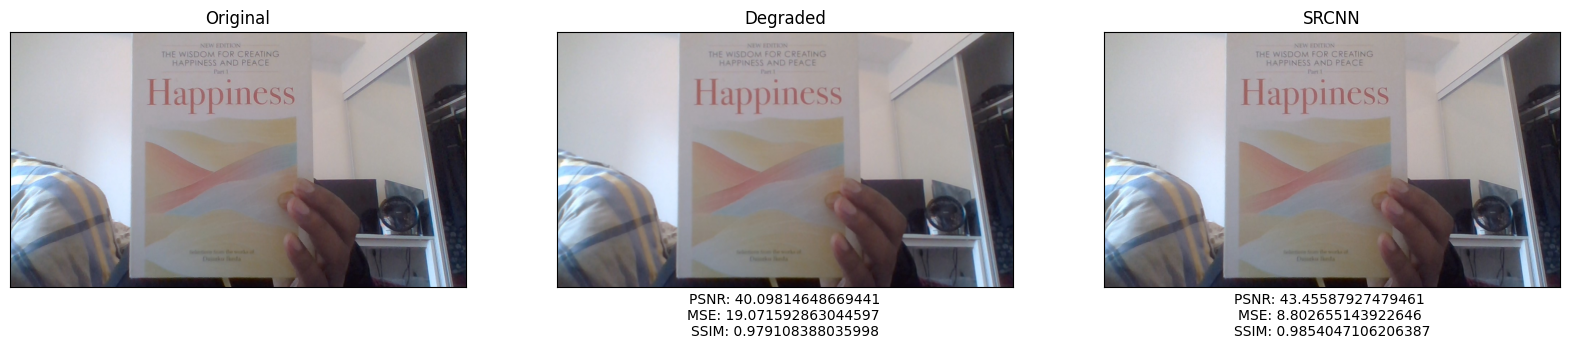

In [ ]:
# Performing Super Resolution using our SRCNN model on all images (degraded)

for file in os.listdir('images'):
    # perform super-resolution
    try:
      ref, degraded, output, scores = predict('images/{}'.format(file))
    except:
      continue


    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    print('Saving {}'.format(file))
    fig.savefig('output/{}.png'.format(os.path.splitext(file)[0]))
    plt.close()